In [3]:
import geopandas as gpd
import pandas as pd
import glob

# 1. 모든 txt 파일에서 고령 인구 데이터 만들기 (이전과 동일)
txt_files = glob.glob("./10km/txt_data/*.txt")
df_list = []

for file in txt_files:
    df = pd.read_csv(file, sep="\\^", header=None, engine="python")
    df.columns = ["year", "grid_id", "age_code", "count"]
    df_list.append(df)

df_all = pd.concat(df_list, ignore_index=True)
df_all["age"] = df_all["age_code"].str.extract(r"in_age_(\d+)")[0].astype(float)
df_all = df_all.dropna(subset=["age"])
df_all["age"] = df_all["age"].astype(int)
df_elder = df_all[df_all["age"] >= 65]
df_elder_sum = df_elder.groupby("grid_id")["count"].sum().reset_index()
df_elder_sum.columns = ["GRID_10K_C", "elderly_pop"]

# 2. 모든 grid_XX_10K.shp 병합
shp_files = glob.glob("./10km/grid/grid_*_10K.shp")  # 폴더 경로에 맞게 수정
gdf_list = [gpd.read_file(shp) for shp in shp_files]
gdf_all = pd.concat(gdf_list, ignore_index=True)

# 3. 고령 인구 병합
gdf_all = gdf_all.merge(df_elder_sum, on="GRID_10K_C", how="left")
gdf_all["elderly_pop"] = gdf_all["elderly_pop"].fillna(0).astype(int)

# 4. 저장
gdf_all.to_file("grid_with_elderly_10K.gpkg", driver="GPKG")
print("✅ 전국 격자 + 고령 인구 결합 완료 → grid_with_elderly_10K.geojson 저장됨")

✅ 전국 격자 + 고령 인구 결합 완료 → grid_with_elderly_10K.geojson 저장됨


In [5]:
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd

# 1. 격자 및 병원 데이터 불러오기
gdf_grid = gpd.read_file("grid_with_elderly_10K.gpkg")
gdf_grid = gdf_grid.to_crs(epsg=5181)  # 미터 단위 좌표계로 변환

# 병원 예시 데이터
hospital_data = pd.read_csv("hospitals.csv")  # 또는 위에서 만든 hospital_data 사용
hospital_data["geometry"] = hospital_data.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
gdf_hosp = gpd.GeoDataFrame(hospital_data, geometry="geometry", crs="EPSG:4326").to_crs("EPSG:5181")

# 버퍼 거리 설정 (예: 10km = 10000m)
BUFFER_RADIUS = 10000

# 2SFCA Step 1: 병원 중심으로 10km 내 인구 합산 후 공급비율 계산
ratios = []
for idx, hosp in gdf_hosp.iterrows():
    buffer = hosp.geometry.buffer(BUFFER_RADIUS)
    nearby_grids = gdf_grid[gdf_grid.geometry.intersects(buffer)]
    total_pop = nearby_grids["elderly_pop"].sum()
    ratio = hosp["doctors"] / total_pop if total_pop > 0 else 0
    ratios.append(ratio)

gdf_hosp["supply_ratio"] = ratios

# Step 2: 격자 중심으로 10km 내 병원들의 공급비율 합산
accessibility_scores = []
for idx, grid in gdf_grid.iterrows():
    buffer = grid.geometry.centroid.buffer(BUFFER_RADIUS)
    nearby_hosp = gdf_hosp[gdf_hosp.geometry.intersects(buffer)]
    score = nearby_hosp["supply_ratio"].sum()
    accessibility_scores.append(score)

gdf_grid["accessibility_index"] = accessibility_scores

# 저장
gdf_grid.to_file("grid_with_accessibility_10K.gpkg", driver="GPKG")
print("✅ 2SFCA 계산 완료 → grid_with_accessibility_10K.gpkg 저장됨")


✅ 2SFCA 계산 완료 → grid_with_accessibility_10K.gpkg 저장됨


C:\Users\Playdata\AppData\Local\Temp\ipykernel_2616\2003157722.py:29: UserWarning: Glyph 51217 (\N{HANGUL SYLLABLE JEOB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Playdata\AppData\Local\Temp\ipykernel_2616\2003157722.py:29: UserWarning: Glyph 44540 (\N{HANGUL SYLLABLE GEUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Playdata\AppData\Local\Temp\ipykernel_2616\2003157722.py:29: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Playdata\AppData\Local\Temp\ipykernel_2616\2003157722.py:29: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Playdata\AppData\Local\Temp\ipykernel_2616\2003157722.py:29: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Playdata\AppData\Local\Temp\ipykernel_2616\2003157722.py:29: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE 

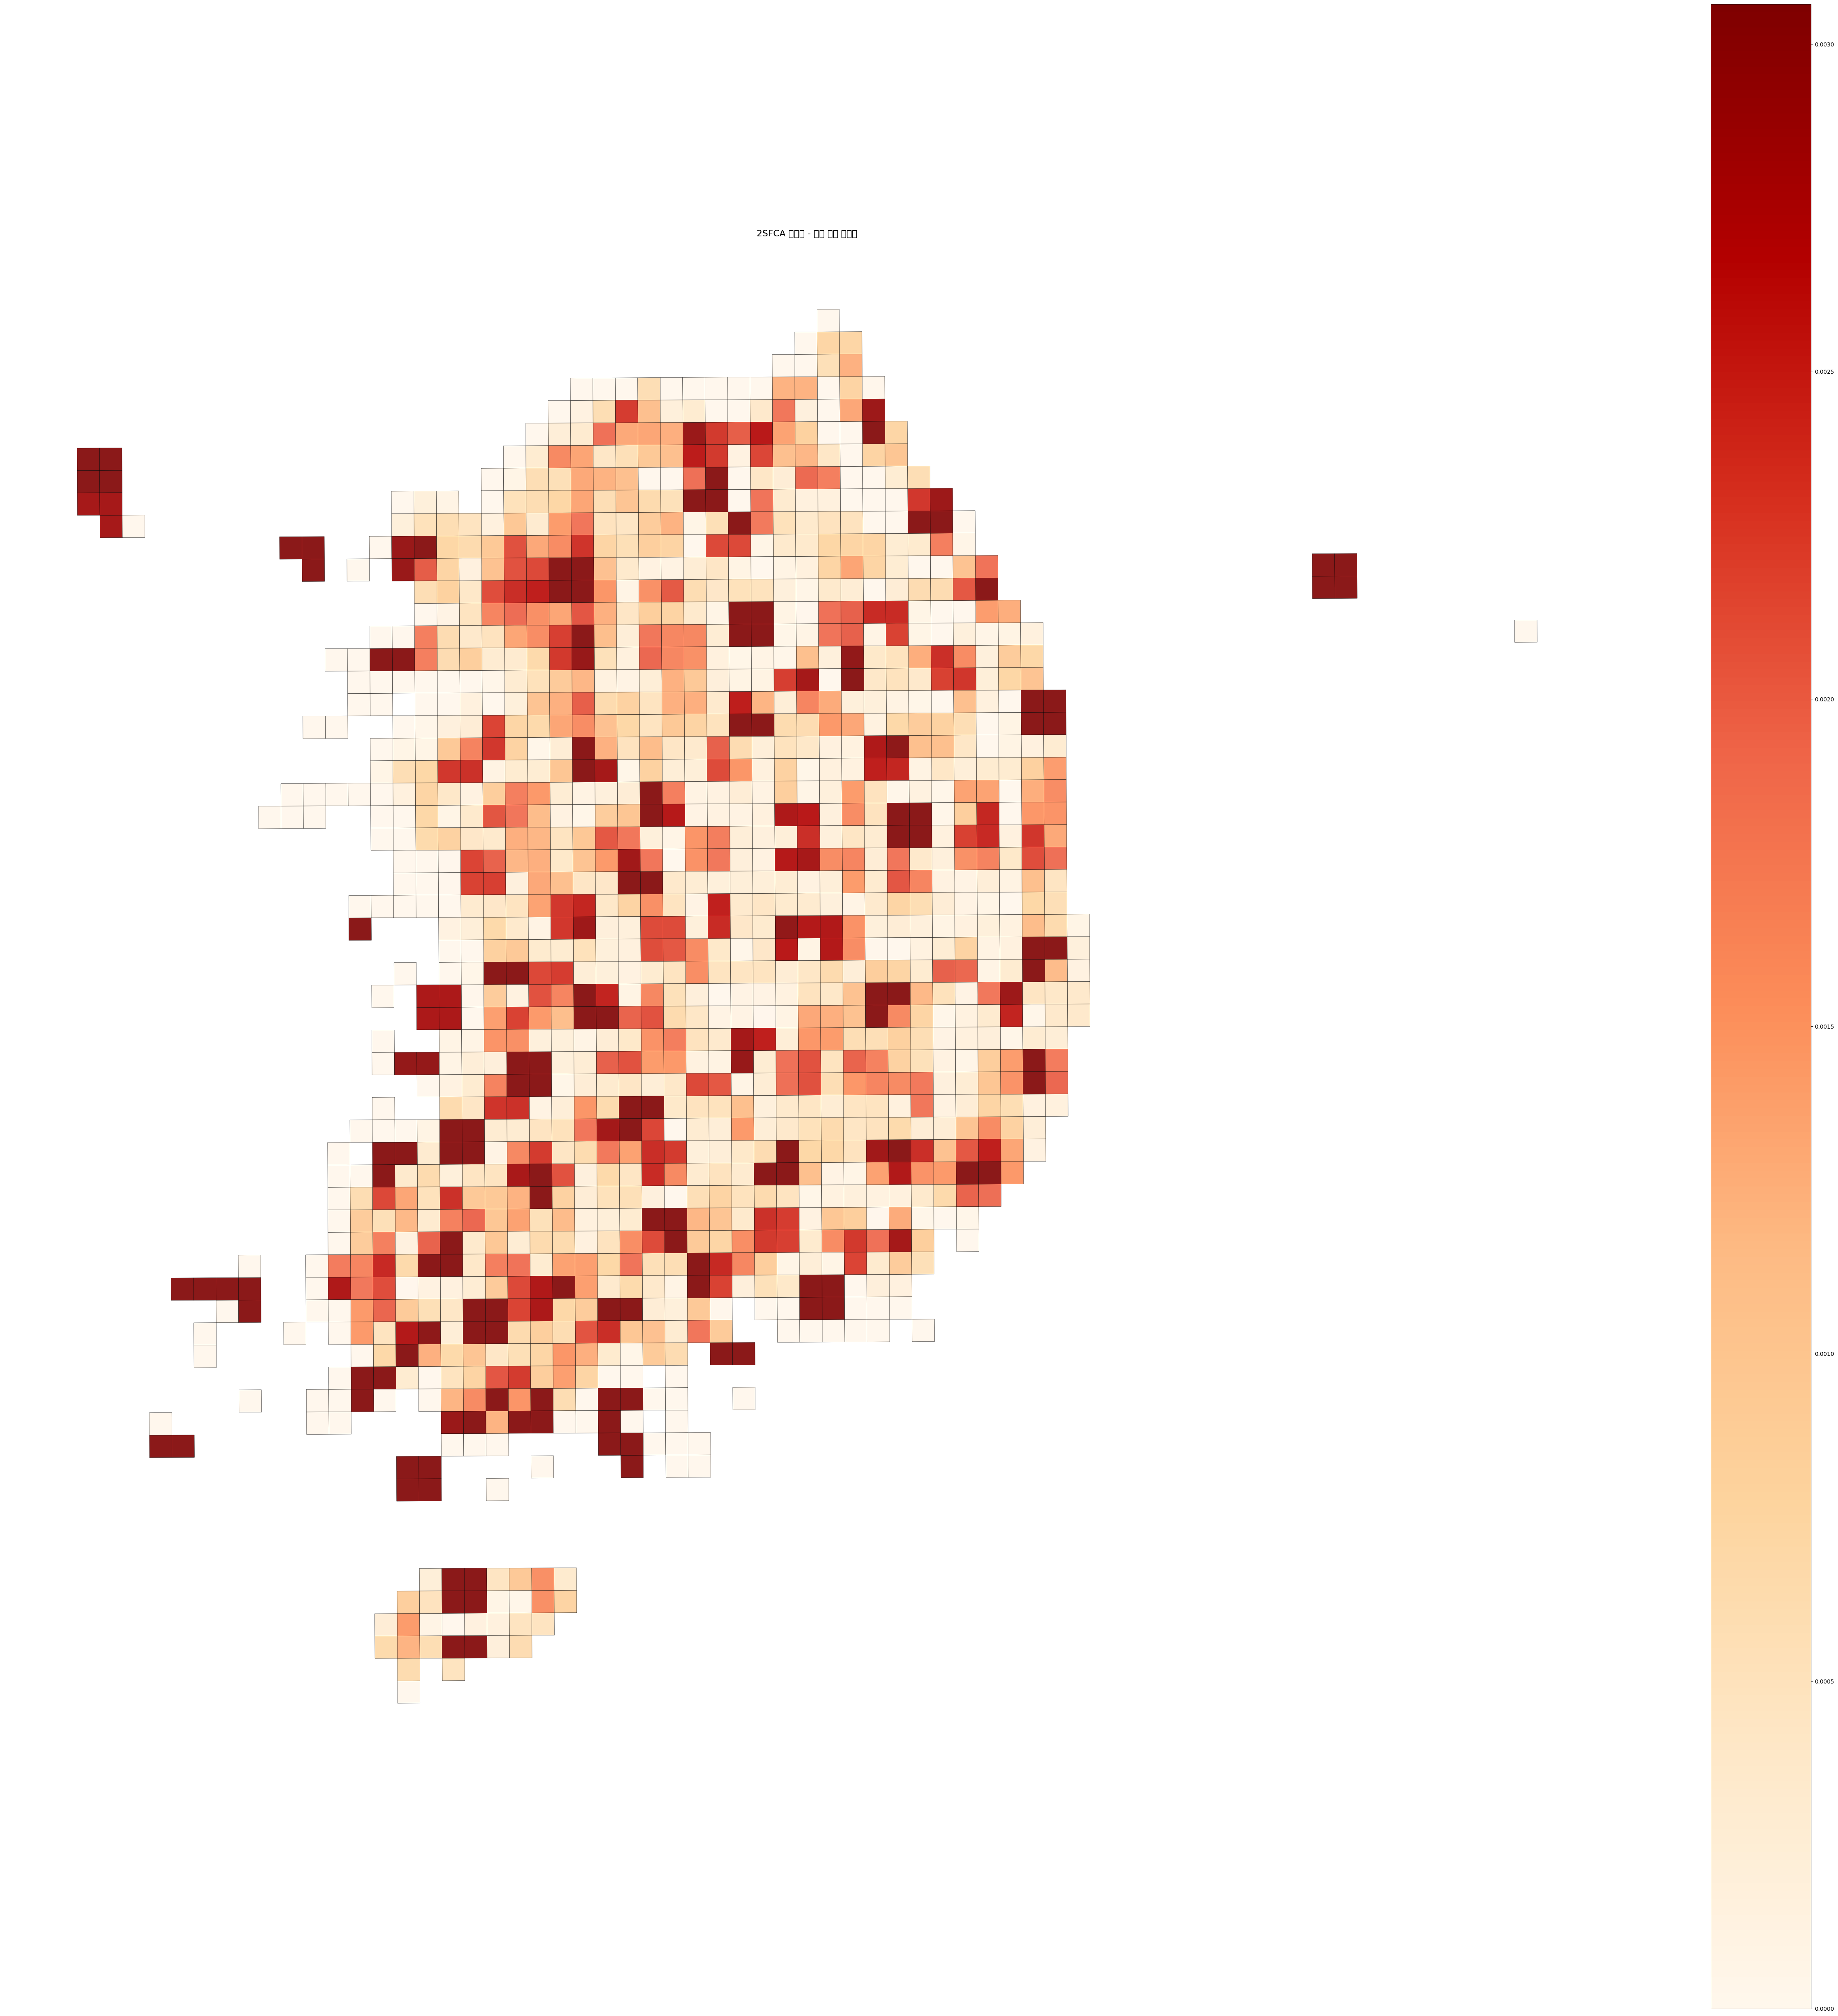

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
gdf = gpd.read_file("grid_with_accessibility_10K.gpkg")

# 2. figure 사이즈 키우기
fig, ax = plt.subplots(1, 1, figsize=(50, 50))  # 가로x세로 (inch)

# 3. 이상값 제한 (optional)
vmin = gdf["accessibility_index"].quantile(0.05)
vmax = gdf["accessibility_index"].quantile(0.9)


gdf.plot(
    column="accessibility_index",
    cmap="OrRd",
    legend=True,
    linewidth=0.4,
    edgecolor="black",  # 경계선 강조
    alpha=0.9,           # 불투명하게
    ax=ax,
    vmin=vmin,
    vmax=vmax
)

ax.set_title("2SFCA 접근성 - 격자 기반 시각화", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.show()

In [27]:
gdf.geom_type.value_counts()


Polygon    107661
Name: count, dtype: int64

In [ ]:
import geopandas as gpd
import pandas as pd
import glob

# 1. 모든 txt 파일에서 고령 인구 데이터 만들기 (이전과 동일)
txt_files = glob.glob("./1km/txt_data/*.txt")
df_list = []

for file in txt_files:
    df = pd.read_csv(file, sep="\\^", header=None, engine="python")
    df.columns = ["year", "grid_id", "age_code", "count"]
    df_list.append(df)

df_all = pd.concat(df_list, ignore_index=True)
df_all["age"] = df_all["age_code"].str.extract(r"in_age_(\d+)")[0].astype(float)
df_all = df_all.dropna(subset=["age"])
df_all["age"] = df_all["age"].astype(int)
df_elder = df_all[df_all["age"] >= 65]
df_elder_sum = df_elder.groupby("grid_id")["count"].sum().reset_index()
df_elder_sum.columns = ["GRID_1K_CD", "elderly_pop"]

# 2. 모든 grid_XX_10K.shp 병합
shp_files = glob.glob("./1km/grid/grid_*_1K.shp")  # 폴더 경로에 맞게 수정
gdf_list = [gpd.read_file(shp) for shp in shp_files]
gdf_all = pd.concat(gdf_list, ignore_index=True)

# 3. 고령 인구 병합
gdf_all = gdf_all.merge(df_elder_sum, on="GRID_1K_CD", how="left")
gdf_all["elderly_pop"] = gdf_all["elderly_pop"].fillna(0).astype(int)

# 4. 저장
gdf_all.to_file("grid_with_elderly_1K.gpkg", driver="GPKG")
print("✅ 전국 격자 + 고령 인구 결합 완료 → grid_with_elderly_1K.geojson 저장됨")

✅ 전국 격자 + 고령 인구 결합 완료 → grid_with_elderly_1K.geojson 저장됨


In [ ]:
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd

# 1. 격자 및 병원 데이터 불러오기
gdf_grid = gpd.read_file("grid_with_elderly_1K.gpkg")
gdf_grid = gdf_grid.to_crs(epsg=5181)  # 미터 단위 좌표계로 변환

# 병원 예시 데이터
hospital_data = pd.read_csv("hospitals.csv")  # 또는 위에서 만든 hospital_data 사용
hospital_data["geometry"] = hospital_data.apply(lambda row: Point(row["lon"], row["lat"]), axis=1)
gdf_hosp = gpd.GeoDataFrame(hospital_data, geometry="geometry", crs="EPSG:4326").to_crs("EPSG:5181")

# 버퍼 거리 설정 (예: 10km = 10000m)
BUFFER_RADIUS = 10000

# 2SFCA Step 1: 병원 중심으로 10km 내 인구 합산 후 공급비율 계산
ratios = []
for idx, hosp in gdf_hosp.iterrows():
    buffer = hosp.geometry.buffer(BUFFER_RADIUS)
    nearby_grids = gdf_grid[gdf_grid.geometry.intersects(buffer)]
    total_pop = nearby_grids["elderly_pop"].sum()
    ratio = hosp["doctors"] / total_pop if total_pop > 0 else 0
    ratios.append(ratio)

gdf_hosp["supply_ratio"] = ratios

# Step 2: 격자 중심으로 10km 내 병원들의 공급비율 합산
accessibility_scores = []
for idx, grid in gdf_grid.iterrows():
    buffer = grid.geometry.centroid.buffer(BUFFER_RADIUS)
    nearby_hosp = gdf_hosp[gdf_hosp.geometry.intersects(buffer)]
    score = nearby_hosp["supply_ratio"].sum()
    accessibility_scores.append(score)

gdf_grid["accessibility_index"] = accessibility_scores

# 저장
gdf_grid.to_file("grid_with_accessibility_1K.gpkg", driver="GPKG")
print("✅ 2SFCA 계산 완료 → grid_with_accessibility_1K.gpkg 저장됨")




✅ 2SFCA 계산 완료 → grid_with_accessibility.gpkg 저장됨


C:\Users\Playdata\AppData\Local\Temp\ipykernel_2616\3753979422.py:27: UserWarning: Glyph 51217 (\N{HANGUL SYLLABLE JEOB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Playdata\AppData\Local\Temp\ipykernel_2616\3753979422.py:27: UserWarning: Glyph 44540 (\N{HANGUL SYLLABLE GEUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Playdata\AppData\Local\Temp\ipykernel_2616\3753979422.py:27: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Playdata\AppData\Local\Temp\ipykernel_2616\3753979422.py:27: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Playdata\AppData\Local\Temp\ipykernel_2616\3753979422.py:27: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Playdata\AppData\Local\Temp\ipykernel_2616\3753979422.py:27: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE 

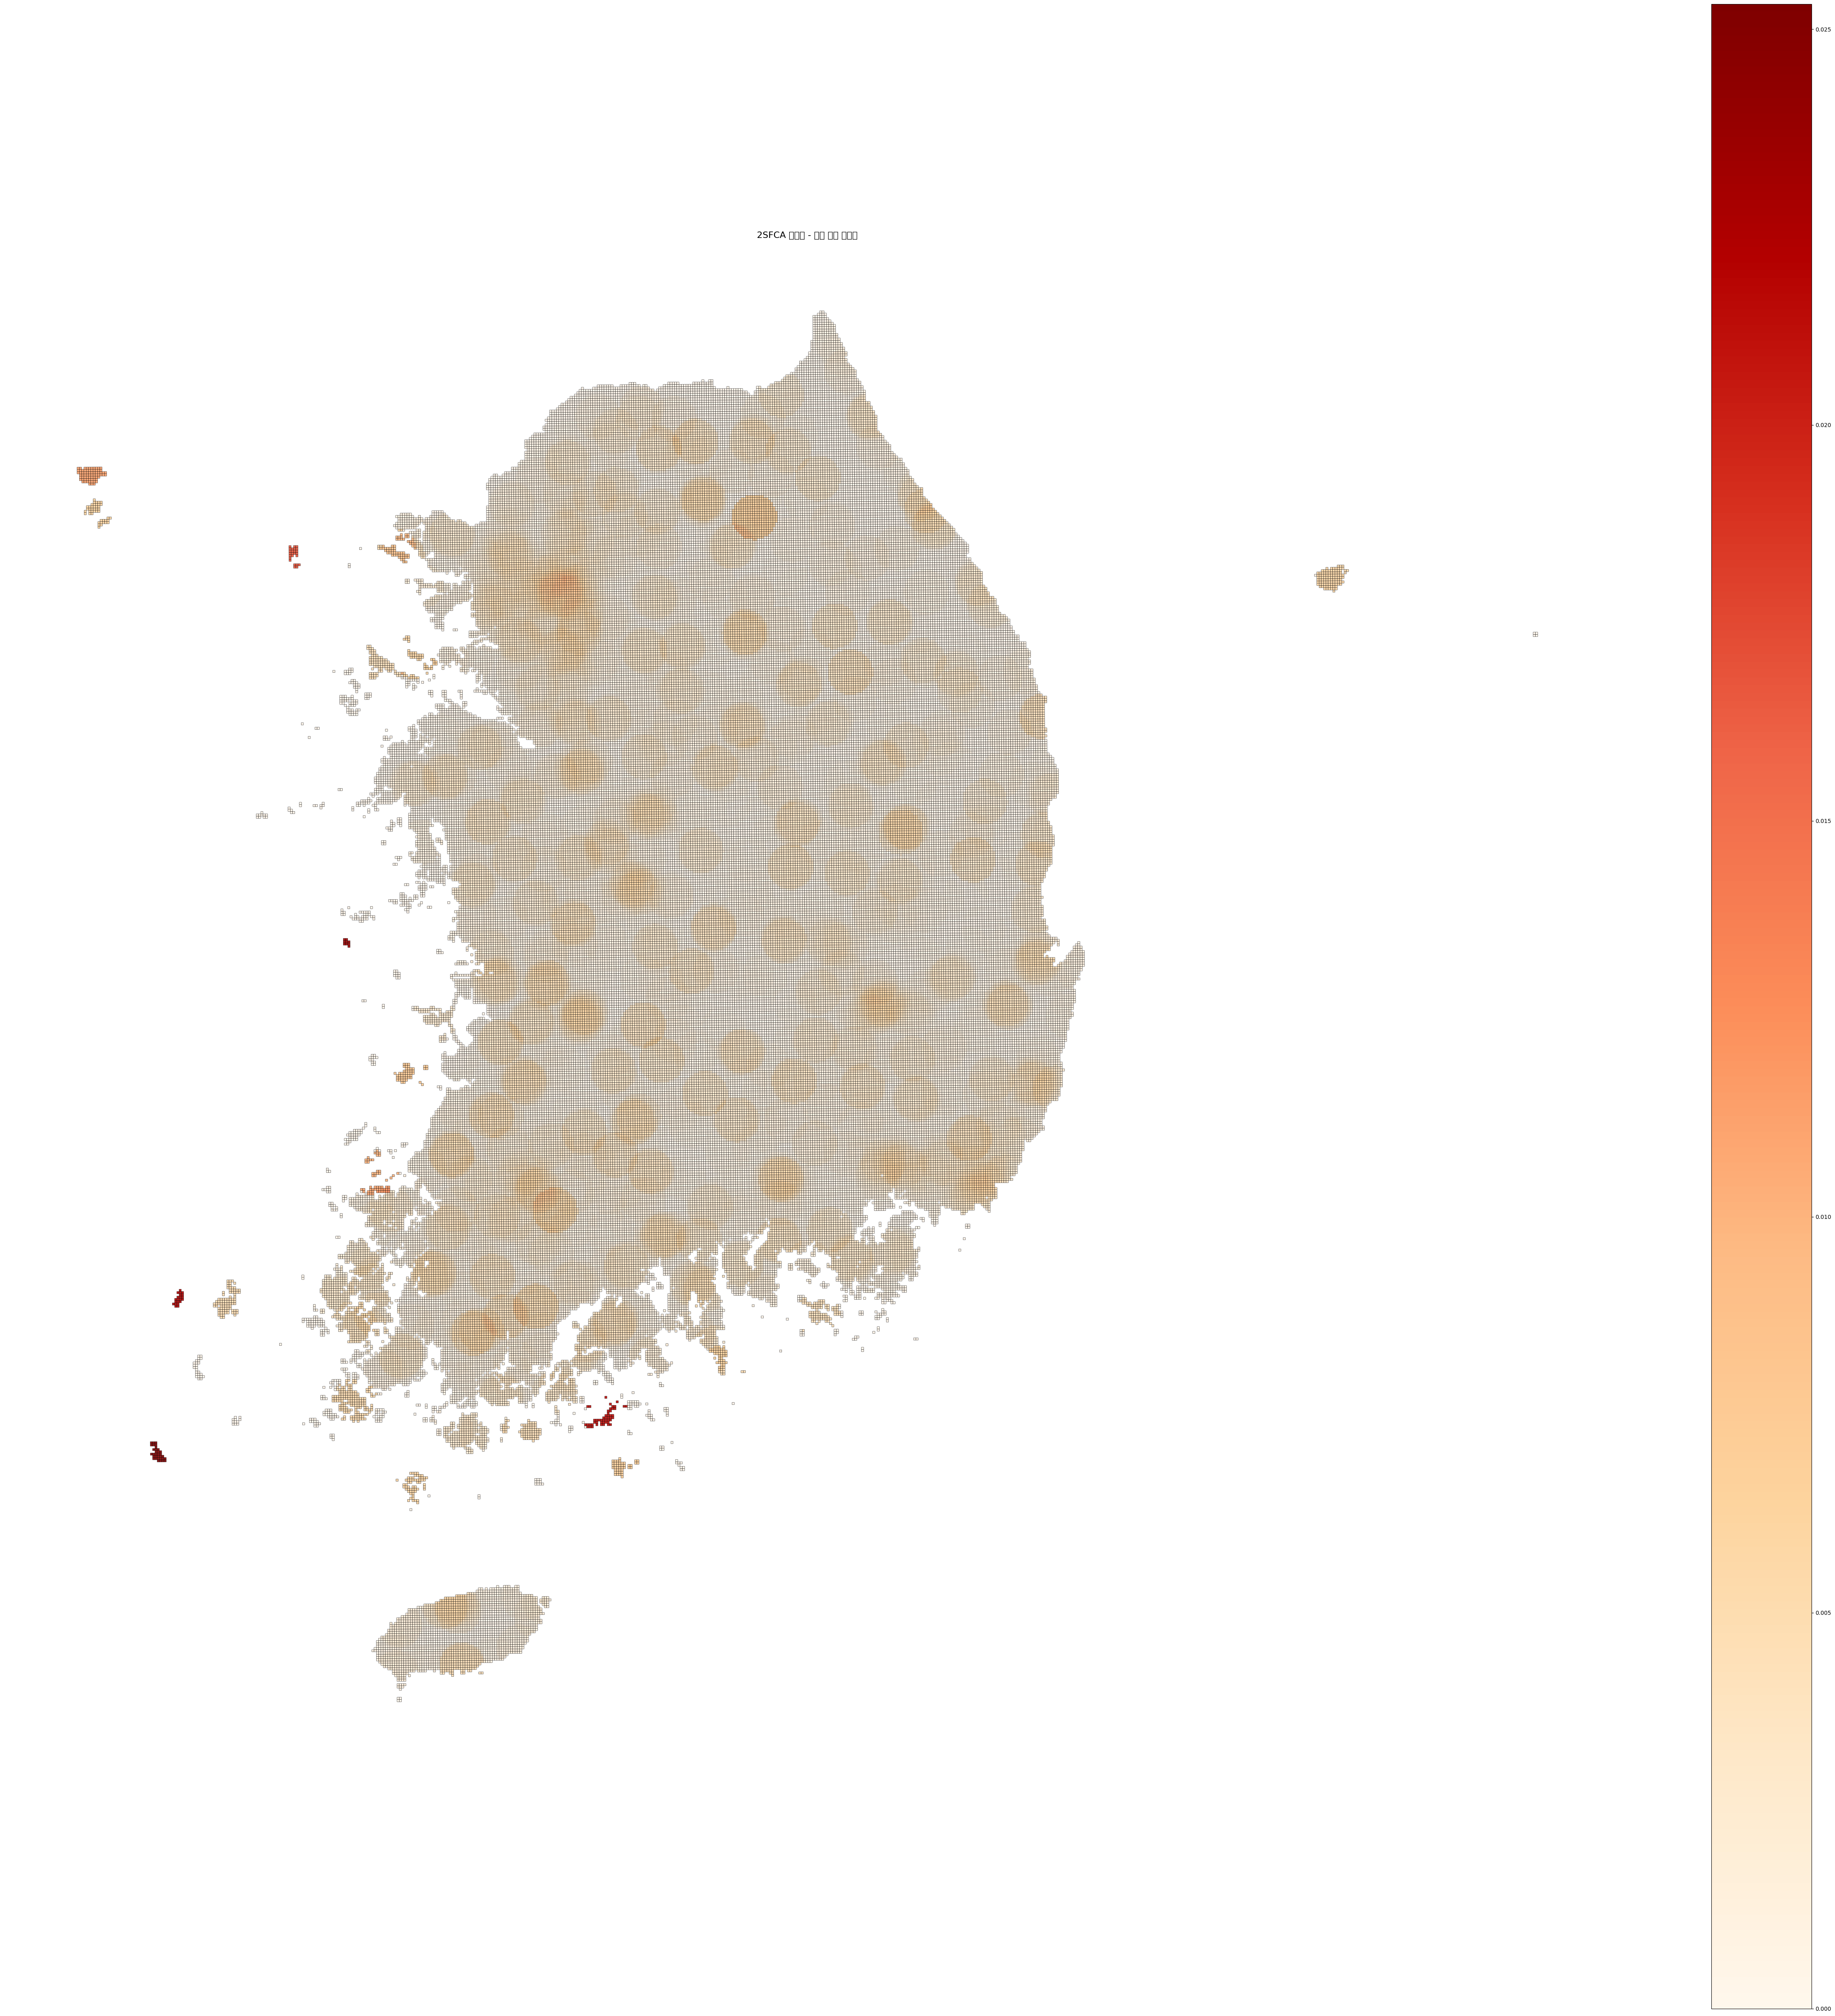

In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. 데이터 불러오기
gdf = gpd.read_file("grid_with_accessibility_1K.gpkg")

# 2. figure 사이즈 키우기
fig, ax = plt.subplots(1, 1, figsize=(50, 50))  # 가로x세로 (inch)

# # 3. 이상값 제한 (optional)
# vmin = gdf["accessibility_index"].quantile(0.05)
# vmax = gdf["accessibility_index"].quantile(0.5)


gdf.plot(
    column="accessibility_index",
    cmap="OrRd",
    legend=True,
    linewidth=0.4,
    edgecolor="black",  # 경계선 강조
    alpha=0.9,           # 불투명하게
    ax=ax
)

ax.set_title("2SFCA 접근성 - 격자 기반 시각화", fontsize=16)
ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# GeoJSON 파일 읽기
gdf = gpd.read_file("grid_with_elderly.gpkg")

# 내용 확인
print(gdf)
print(gdf.columns)
print(gdf.crs)  # 좌표계 확인

       GRID_1K_CD  elderly_pop  \
0          가다7964            0   
1          가다8064           20   
2          가다8164          108   
3          가다8264            0   
4          가다7765            0   
...           ...          ...   
107656     사사0154            5   
107657     사사0254            0   
107658     사사0055            0   
107659     사사0155            0   
107660     사사0255            0   

                                                 geometry  
0       POLYGON ((779000 1564000, 779000 1565000, 7800...  
1       POLYGON ((780000 1564000, 780000 1565000, 7810...  
2       POLYGON ((781000 1564000, 781000 1565000, 7820...  
3       POLYGON ((782000 1564000, 782000 1565000, 7830...  
4       POLYGON ((777000 1565000, 777000 1566000, 7780...  
...                                                   ...  
107656  POLYGON ((1301000 1954000, 1301000 1955000, 13...  
107657  POLYGON ((1302000 1954000, 1302000 1955000, 13...  
107658  POLYGON ((1300000 1955000, 1300000 1956000,

In [6]:
print("총 격자 수:", len(gdf_all))
print("고유 격자 수:", gdf_all["GRID_1K_CD"].nunique())

# 격자 ID 중복 여부
dupes = gdf_all["GRID_1K_CD"].duplicated(keep=False)
print("중복 격자 수:", dupes.sum())

# 고령 인구 분포 확인
print(gdf_all["elderly_pop"].describe())

# 병합이 이상하게 되었는지 샘플 보기
print(gdf_all.sort_values("elderly_pop", ascending=False)[["GRID_1K_CD", "elderly_pop"]].head())


총 격자 수: 107661
고유 격자 수: 107661
중복 격자 수: 0
count    107661.000000
mean        210.042169
std        1105.984854
min           0.000000
25%           0.000000
50%          10.000000
75%          49.000000
max       21264.000000
Name: elderly_pop, dtype: float64
      GRID_1K_CD  elderly_pop
39841     다사6748        21264
39253     다사5142        20767
39816     다사4248        19764
39349     다사4943        19500
39446     다사4944        19494


In [7]:
print(gdf_all["elderly_pop"].describe())

count    107661.000000
mean        210.042169
std        1105.984854
min           0.000000
25%           0.000000
50%          10.000000
75%          49.000000
max       21264.000000
Name: elderly_pop, dtype: float64


In [8]:
gdf.sort_values("elderly_pop", ascending=False)[["GRID_1K_CD", "elderly_pop"]].head(10)

GRID_1K_CD  elderly_pop
39841     다사6748        21264
39253     다사5142        20767
39816     다사4248        19764
39349     다사4943        19500
39446     다사4944        19494
40257     다사4853        19118
40538     다사4856        18817
39815     다사4148        18469
40440     다사4855        18447
39910     다사4149        18072